In [57]:
import pandas as pd
import os
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import umap

In [15]:
# Get the list of CSV files in the data folder
data_folder = 'data'
csv_files = [file for file in os.listdir(data_folder) if file.endswith('.csv')]

# Dictionary to store the dataframes
dataframes = {}

# Load each CSV file into a dataframe
for file in csv_files:
    # Create a dataframe name from the file name (removing .csv extension)
    df_name = file.replace('.csv', '')
    
    # Load the dataframe
    file_path = os.path.join(data_folder, file)
    dataframes[df_name] = pd.read_csv(file_path)
"""
# Display the names of the dataframes and their heads
print(f"Found {len(dataframes)} CSV files:")
print("-" * 50)

for df_name, df in dataframes.items():
    print(f"DataFrame name: {df_name}")
    print("-" * 50)
    display(df.head())
    print(f"Shape: {df.shape}")
    print("\n" + "=" * 70 + "\n")
"""

'\n# Display the names of the dataframes and their heads\nprint(f"Found {len(dataframes)} CSV files:")\nprint("-" * 50)\n\nfor df_name, df in dataframes.items():\n    print(f"DataFrame name: {df_name}")\n    print("-" * 50)\n    display(df.head())\n    print(f"Shape: {df.shape}")\n    print("\n" + "=" * 70 + "\n")\n'

In [16]:
# List all dataframe names
print("List of all dataframe names:")
for i, name in enumerate(dataframes.keys(), 1):
    print(f"{i}. {name}")

merged_data_cleaned = dataframes['merged_data_cleaned']


List of all dataframe names:
1. arabica_data_cleaned
2. merged_data_cleaned
3. ml_merged_data_cleaned
4. robusta_data_cleaned


In [17]:
# Preprocessing merged_data_cleaned

# 1. Keep only the specified columns
columns_to_keep = ['Species', 'Country.of.Origin', 'Harvest.Year', 'Color', 'Processing.Method', 'Aroma', 
                  'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 
                  'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points', 
                  'Total.Cup.Points']

merged_data_cleaned = merged_data_cleaned[columns_to_keep]

# Create a summary of unique, NaN, and null values for each column
summary = pd.DataFrame({
    'Column': merged_data_cleaned.columns,
    'Unique Values': [merged_data_cleaned[col].nunique() for col in merged_data_cleaned.columns],
    'NaN Values': [merged_data_cleaned[col].isna().sum() for col in merged_data_cleaned.columns],
    'Null Values': [merged_data_cleaned[col].isnull().sum() for col in merged_data_cleaned.columns]
}).set_index('Column')

# Display the summary
display(summary)

,Unique Values,NaN Values,Null Values
Column,,,
Species,2,0,0
Country.of.Origin,36,1,1
Harvest.Year,46,47,47
Color,3,270,270
Processing.Method,5,170,170
Aroma,33,0,0
Flavor,35,0,0
Aftertaste,35,0,0
Acidity,31,0,0


In [18]:
# 2. Rename columns to replace dots with underscores
merged_data_cleaned.columns = [col.replace('.', '_') for col in merged_data_cleaned.columns]

# 3. Display the total number of records
total_records = len(merged_data_cleaned)
print(f"Total number of records: {total_records}")

# 4. Remove records with NaN or null values and display the count
merged_data_cleaned = merged_data_cleaned.dropna()
records_after_cleaning = len(merged_data_cleaned)
print(f"Number of records after removing NaN/null values: {records_after_cleaning}")
print(f"Removed {total_records - records_after_cleaning} records with missing values")

# Display the first few rows of the cleaned dataframe
merged_data_cleaned.head()

Total number of records: 1339
Number of records after removing NaN/null values: 1012
Removed 327 records with missing values


,Species,Country_of_Origin,Harvest_Year,Color,Processing_Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean_Cup,Sweetness,Cupper_Points,Total_Cup_Points
0,Arabica,Ethiopia,2014,Green,Washed / Wet,8.67,8.83,8.67,8.75,8.50,8.42,10.0,10.0,10.0,8.75,90.58
1,Arabica,Ethiopia,2014,Green,Washed / Wet,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,10.0,8.58,89.92
3,Arabica,Ethiopia,2014,Green,Natural / Dry,8.17,8.58,8.42,8.42,8.50,8.25,10.0,10.0,10.0,8.67,89.00
4,Arabica,Ethiopia,2014,Green,Washed / Wet,8.25,8.50,8.25,8.50,8.42,8.33,10.0,10.0,10.0,8.58,88.83
5,Arabica,Brazil,2013,Bluish-Green,Natural / Dry,8.58,8.42,8.42,8.50,8.25,8.33,10.0,10.0,10.0,8.33,88.83


In [19]:
# Precheck for standardization
# List of string columns
string_cols = [
    "Species",
    "Country_of_Origin",
    "Harvest_Year",
    "Color",
    "Processing_Method"
]

# Loop through and print unique values
for col in string_cols:
    print(f"\n--- {col} ---")
    print(merged_data_cleaned[col].unique())
    print(f"Total unique values: {merged_data_cleaned[col].nunique()}")



--- Species ---
['Arabica' 'Robusta']
Total unique values: 2

--- Country_of_Origin ---
['Ethiopia' 'Brazil' 'Peru' 'China' 'Costa Rica' 'Mexico' 'Uganda'
 'Taiwan' 'Tanzania, United Republic Of' 'Kenya' 'Thailand' 'Colombia'
 'Guatemala' 'Panama' 'Papua New Guinea' 'El Salvador' 'Indonesia'
 'United States (Hawaii)' 'Honduras' 'Nicaragua' 'Ecuador'
 'United States (Puerto Rico)' 'Haiti' 'Vietnam' 'Philippines' 'Rwanda'
 'Malawi' 'Laos' 'Myanmar' 'Cote d?Ivoire' 'India' 'United States']
Total unique values: 32

--- Harvest_Year ---
['2014' '2013' '2012' '2015' '2011' '2015/2016' '2016' '2017' '2013/2014'
 '2017 / 2018' '2014/2015' '2011/2012' '2016 / 2017' '2018']
Total unique values: 14

--- Color ---
['Green' 'Bluish-Green' 'Blue-Green']
Total unique values: 3

--- Processing_Method ---
['Washed / Wet' 'Natural / Dry' 'Pulped natural / honey'
 'Semi-washed / Semi-pulped' 'Other']
Total unique values: 5


In [20]:
# Fixes
# Country_of_Origin 
merged_data_cleaned["Country_of_Origin"] = merged_data_cleaned["Country_of_Origin"].replace("Cote d?Ivoire", "Ivory Coast")
merged_data_cleaned["Country_of_Origin"] = merged_data_cleaned["Country_of_Origin"].replace("Tanzania, United Republic Of", "Tanzania")

# Harvest_Year
merged_data_cleaned["Harvest_Year"] = merged_data_cleaned["Harvest_Year"].astype(str).str.split("/").str[0].str.strip().astype(int)

# Color
merged_data_cleaned["Color"] = merged_data_cleaned["Color"].replace("Bluish-Green", "Blue-Green")
"""
# Loop through and print unique values
for col in merged_data_cleaned.columns:
    print(f"\n--- {col} ---")
    print(merged_data_cleaned[col].value_counts())
    print(f"Total unique values: {merged_data_cleaned[col].nunique()}")
"""

'\n# Loop through and print unique values\nfor col in merged_data_cleaned.columns:\n    print(f"\n--- {col} ---")\n    print(merged_data_cleaned[col].value_counts())\n    print(f"Total unique values: {merged_data_cleaned[col].nunique()}")\n'

In [21]:
# Define sensory columns and their tag names
sensory_tags = {
    'Sweetness': 'Sweet',
    'Acidity': 'Sour',
    'Body': 'Full-bodied',
    'Aftertaste': 'Lingering'
}

# Calculate 75th and 25th percentile cutoffs
cutoffs_high = merged_data_cleaned[list(sensory_tags.keys())].quantile(0.75)
cutoffs_low = merged_data_cleaned[['Acidity']].quantile(0.25)  # only for Smooth

# Function to assign readable tags
def categorize_coffee(row):
    categories = []
    
    # Upper quartile sensory tags
    for col, tag in sensory_tags.items():
        if row[col] >= cutoffs_high[col]:
            categories.append(tag)
    
    # Low-acidity → Smooth
    if row['Acidity'] <= cutoffs_low['Acidity']:
        categories.append('Smooth')
    
    # Aroma tag (high = Aromatic)
    if row['Aroma'] >= merged_data_cleaned['Aroma'].quantile(0.75):
        categories.append('Aromatic')
    
    # Aftertaste tag (high = Complex)
    if row['Aftertaste'] >= merged_data_cleaned['Aftertaste'].quantile(0.75):
        categories.append('Complex')
    
    # Quality Tier from Total Cup Points
    score = row['Total_Cup_Points']
    if score >= 90:
        categories.append('Elite')
    elif score >= 85:
        categories.append('Premium')
    elif score >= 80:
        categories.append('Specialty')
    else:
        categories.append('Below Specialty')
    
    return categories

# Apply to dataframe
merged_data_cleaned['Taste_Categories'] = merged_data_cleaned.apply(categorize_coffee, axis=1)

# Check distribution
print("Details of Taste_Categories:\n")
#print(merged_data_cleaned['Taste_Categories'].apply(tuple).unique())
print(merged_data_cleaned['Taste_Categories'].value_counts())


Details of Taste_Categories:

Taste_Categories
[Sweet, Specialty]                                                           227
[Sweet, Smooth, Specialty]                                                   134
[Sweet, Smooth, Below Specialty]                                              73
[Sweet, Sour, Full-bodied, Lingering, Aromatic, Complex, Premium]             50
[Sweet, Full-bodied, Lingering, Complex, Specialty]                           47
[Sweet, Sour, Full-bodied, Lingering, Aromatic, Complex, Specialty]           46
[Sweet, Full-bodied, Specialty]                                               40
[Sweet, Aromatic, Specialty]                                                  34
[Sweet, Sour, Full-bodied, Lingering, Complex, Specialty]                     30
[Sweet, Sour, Specialty]                                                      26
[Sweet, Lingering, Complex, Specialty]                                        23
[Sweet, Lingering, Aromatic, Complex, Specialty]              

In [22]:
# One hot encoding/Multi label binarization

mlb = MultiLabelBinarizer()
taste_encoded = mlb.fit_transform(merged_data_cleaned['Taste_Categories'])

# Convert back to a dataframe with readable column names
taste_df = pd.DataFrame(taste_encoded, columns=mlb.classes_, index=merged_data_cleaned.index)

# Merge with original dataframe
merged_data_cleaned = pd.concat([merged_data_cleaned, taste_df], axis=1)

taste_df.sum()

Aromatic           285
Below Specialty    130
Complex            325
Elite                1
Full-bodied        338
Lingering          325
Premium             62
Smooth             272
Sour               256
Specialty          819
Sweet              943
dtype: int64

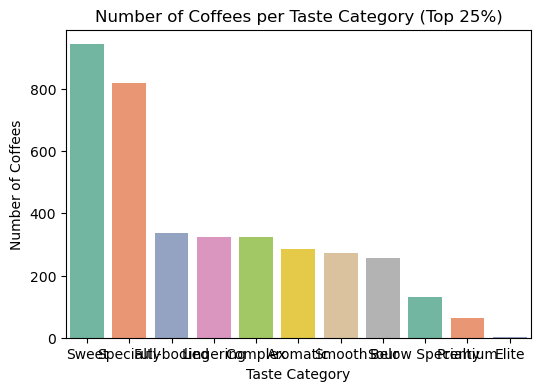

In [23]:
# Count of coffees per tag
tag_counts = merged_data_cleaned['Taste_Categories'].explode().value_counts()

# Bar plot
plt.figure(figsize=(6,4))
sns.barplot(x=tag_counts.index, y=tag_counts.values, hue=tag_counts.index,palette="Set2")
plt.title("Number of Coffees per Taste Category (Top 25%)")
plt.ylabel("Number of Coffees")
plt.xlabel("Taste Category")
plt.show()

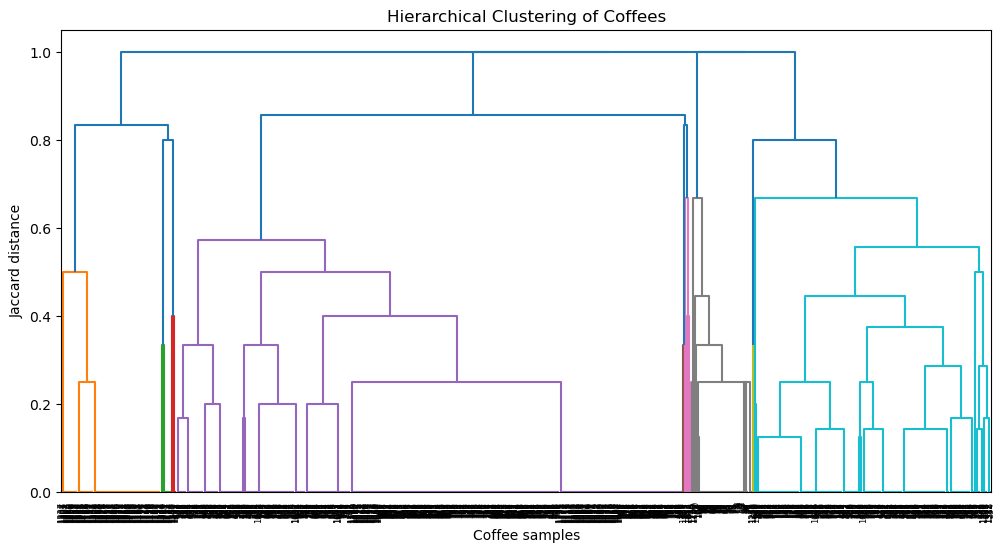

In [43]:
# Hierarchical clustering with Jaccard distance

# --- Step 1: Take a random subset of 200 coffees ---
#subset = taste_df.sample(200, random_state=42)

# --- Step 2: Compute Jaccard distance on this subset ---
jaccard_dist = pdist(taste_df.values, metric="jaccard")

# --- Step 3: Perform hierarchical clustering (average linkage works well here) ---
Z = linkage(jaccard_dist, method="complete")

# --- Step 4: Plot dendrogram ---
plt.figure(figsize=(12, 6))
dendrogram(
    Z, 
    labels=taste_df.index.astype(str),  # use indices as labels
    leaf_rotation=90, 
    leaf_font_size=6
)
plt.title("Hierarchical Clustering of Coffees")
plt.xlabel("Coffee samples")
plt.ylabel("Jaccard distance")
plt.show()

In [54]:
# --- Step 5: Cut the dendrogram into clusters (choose a threshold) ---
clusters = fcluster(Z, t=0.3, criterion="distance")  # tweak t if clusters too many/few
taste_df['Cluster'] = clusters

# --- Step 6: Summarize each cluster by tag frequencies ---
cluster_summary = subset.groupby('Cluster')[taste_df.columns].mean().round(2)

print("Cluster Summary (proportion of coffees with each tag):\n")
print(cluster_summary)

# --- Step 7: Optional – show top 3 tags for each cluster ---
def top_tags(row, n=3):
    return row.sort_values(ascending=False).head(n).index.tolist()

summary_top = cluster_summary.apply(top_tags, axis=1)
print("\nTop tags per cluster:\n")
print(summary_top)

Cluster Summary (proportion of coffees with each tag):

         Aromatic  Below Specialty  Complex  Elite  Full-bodied  Lingering  \
Cluster                                                                      
1            0.17             0.00      0.0    0.0         0.15        0.0   
2            0.56             0.02      1.0    0.0         0.67        1.0   
3            0.00             0.00      1.0    0.0         0.00        1.0   
4            1.00             0.00      0.0    0.0         1.00        0.0   
5            0.00             1.00      0.0    0.0         0.00        0.0   
6            0.33             1.00      0.0    0.0         0.00        0.0   
7            0.00             1.00      1.0    0.0         0.00        1.0   

         Premium  Smooth  Sour  Specialty  Sweet  Cluster  
Cluster                                                    
1           0.00    0.28  0.10       1.00   1.00      1.0  
2           0.16    0.02  0.59       0.83   0.95      2.0  
3

In [55]:
# Jaccard distance matrix (same as you used for clustering)
distance_matrix = squareform(pdist(taste_df.values, metric="jaccard"))

# Cluster labels
labels = clusters

# 1. Silhouette Score (higher = better)
silhouette = silhouette_score(distance_matrix, labels, metric="precomputed")
print("Silhouette Score:", round(silhouette, 3))

# 2. Davies-Bouldin Index (lower = better)
dbi = davies_bouldin_score(taste_df.values, labels)
print("Davies-Bouldin Index:", round(dbi, 3))

# 3. Calinski-Harabasz Index (higher = better)
ch = calinski_harabasz_score(taste_df.values, labels)
print("Calinski-Harabasz Index:", round(ch, 3))

Silhouette Score: 0.776
Davies-Bouldin Index: 0.434
Calinski-Harabasz Index: 8998.586


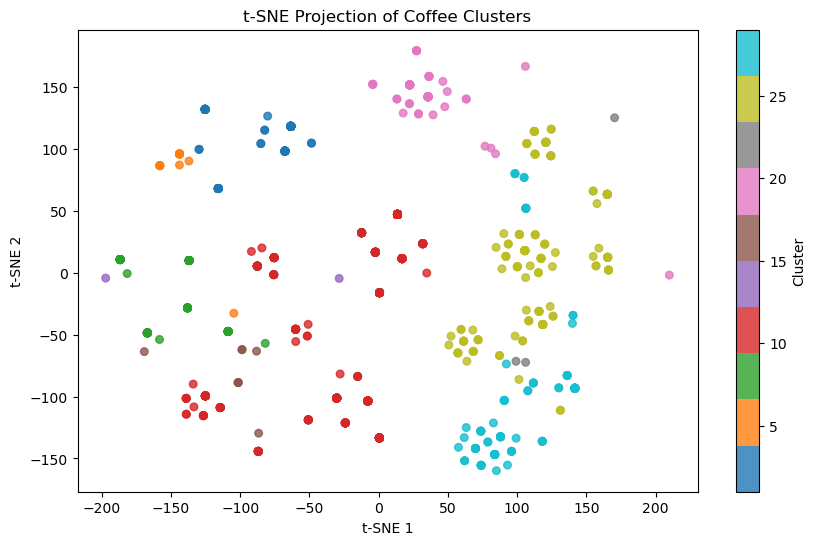

In [58]:
# --- Visualization 1: t-SNE Visualization ---
tsne = TSNE(n_components=2, random_state=42, metric='jaccard')
tsne_results = tsne.fit_transform(taste_df.values)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, cmap='tab10', s=30, alpha=0.8)
plt.title("t-SNE Projection of Coffee Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label='Cluster')
plt.show()

C:\Users\rachn\anaconda3\Lib\site-packages\umap\umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
C:\Users\rachn\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


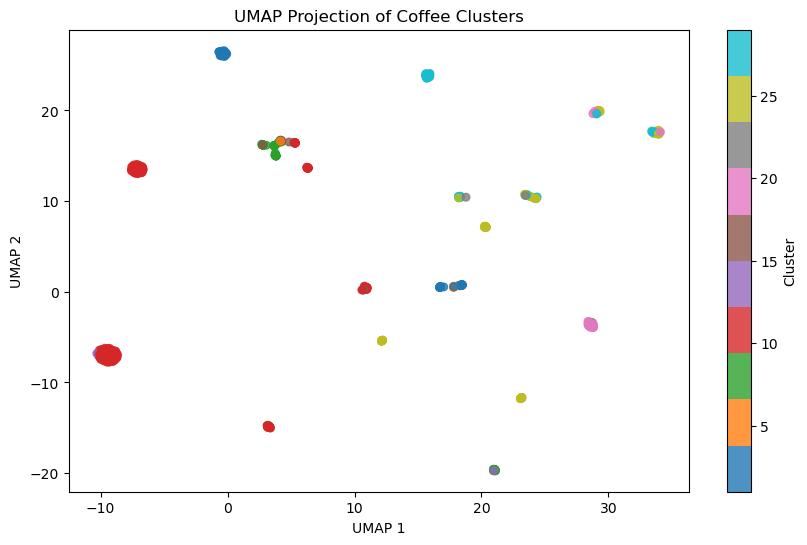

In [59]:
# --- Visualization 2: UMAP Visualization ---
reducer = umap.UMAP(n_components=2, random_state=42, metric='jaccard')
umap_results = reducer.fit_transform(taste_df.values)

plt.figure(figsize=(10, 6))
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=clusters, cmap='tab10', s=30, alpha=0.8)
plt.title("UMAP Projection of Coffee Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label='Cluster')
plt.show()

In [60]:
merged_data_cleaned.to_csv('./data/ml_merged_data_cleaned.csv', index=False)